Statistical errors of CNN models

#read current
#load model and calculate out put od model
#plot 3d error of Bfield

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
if torch.cuda.device_count():
    device = 'cuda'
    map_location = 'cuda:0'
    print('Good to go')
else:
    device = 'cpu'
    map_location = torch.device('cpu')
    print('Using cpu')
    
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset

Good to go


In [2]:
#load saved  model
num_input = 12
output_shape = (3,16,16,16)
SB_args = (64,64,4) # (Cin, Cout, num_block)
BB_args = (2,2) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock

Generative_network = Generative_net(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
Generative_network = torch.load('EMS_CNN.pt', map_location=map_location)
Generative_network.eval()
Generative_network.to(device)

Generative_net(
  (proj): Linear(in_features=12, out_features=4096, bias=True)
  (conv3d): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (total_net): Sequential(
    (0): Linear(in_features=12, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 4, 4, 4))
    (2): BigBlock(
      (block): Sequential(
        (0): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(negative_slope=0.01)
          )
          (shortcut): Identity()
        )
        (1): ResidualEMNSBlock_3d(
          (block): Sequential(
            (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (2): LeakyReLU(ne

In [3]:
#load current and real magnetic field data
from ReadData import ReadCurrentAndField_CNN
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
current,data = ReadCurrentAndField_CNN (foldername,filepattern)

In [4]:
position = data[:,0:3,2:18,2:18,2:18]
Bfield = data[:,3:,2:18,2:18,2:18]
#data normalization
#find min and max value of input position and Bfield
max_current, max_current_index = torch.max(current, dim=0, keepdim=True)
# print(max_current)
min_current, min_current_index = torch.min(current, dim=0, keepdim=True)
# print(min_current)

max_Bfield, max_Bfield_index = torch.max(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.transpose(0,1).reshape(3,-1), dim=1, keepdim=True)
print(min_Bfield)

dimB = Bfield.shape
dimc = current.shape
print(min_current.shape)
print(min_Bfield.shape)

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(current_norm.shape)
print(Bfield_norm.shape)


tensor([[0.0505],
        [0.0564],
        [0.0570]])
tensor([[-0.0529],
        [-0.0534],
        [-0.0612]])
torch.Size([1, 12])
torch.Size([3, 1])
torch.Size([1460, 12])
torch.Size([1460, 3, 16, 16, 16])


In [5]:
num_samples, num_current_input = current.shape
_, dimension, grid_x, grid_y, grid_z = Bfield.shape
grid_space = grid_x*grid_y*grid_z
print(grid_x)
print("current shape:",current.shape,"current device:",current.device)
print("Bfied;:",Bfield.shape,"current device:",Bfield.device)

16
current shape: torch.Size([1460, 12]) current device: cpu
Bfied;: torch.Size([1460, 3, 16, 16, 16]) current device: cpu


In [6]:
#calculate estimated normalized Bfield value of CNN 
B_est_norm=torch.zeros(num_samples,dimension,grid_x,grid_y,grid_z)
for i in range (0,num_samples):
    input=current_norm[i,:].to(device).reshape(1,12)
    b = input.float()
    B_est_norm[i]=Generative_network(b)

B_est=B_est_norm*(0.5*(maxB-minB))+0.5*(maxB+minB)
#calculate rmse 
mse = F.mse_loss(B_est,Bfield,reduction='sum')
rmse = torch.sqrt(mse/num_samples/grid_space)
B_est=B_est.cpu().detach().numpy()
B_est_norm=B_est_norm.cpu().detach().numpy()
Bfield_norm=Bfield_norm.detach().numpy()
current_norm=current_norm.detach().numpy()
Bfield=Bfield.cpu().detach().numpy()


In [7]:
print(B_est_norm.shape)
print(f'rmse={rmse*1000:.2f}mT')
Bdiff_norm=np.absolute(B_est_norm-Bfield_norm)
print(Bdiff_norm.shape)
Error_CNN = Bdiff_norm/np.absolute(Bfield_norm+1e-5)*100
print(B_est.shape)
print(Bfield.shape)

(1460, 3, 16, 16, 16)
rmse=12.96mT
(1460, 3, 16, 16, 16)
(1460, 3, 16, 16, 16)
(1460, 3, 16, 16, 16)


<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\14032\AppData\Local\Temp\ipykernel_34572\2137930729.py:23: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']
C:\Users\14032\AppData\Local\Temp\ipykernel_34572\2137930729.py:23: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']
C:\Users\14032\AppData\Local\Temp\ipykernel_34572\2137930729.py:23: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']


tensor(0.0706)
tensor(0.2372)
torch.Size([1460, 12])


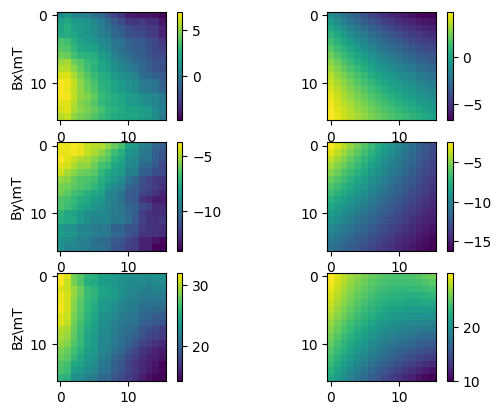

example RMSE: tensor(0.0040)
my RMSE: 0.004038960365126652


<Figure size 640x480 with 0 Axes>

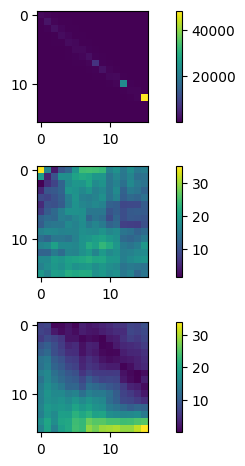

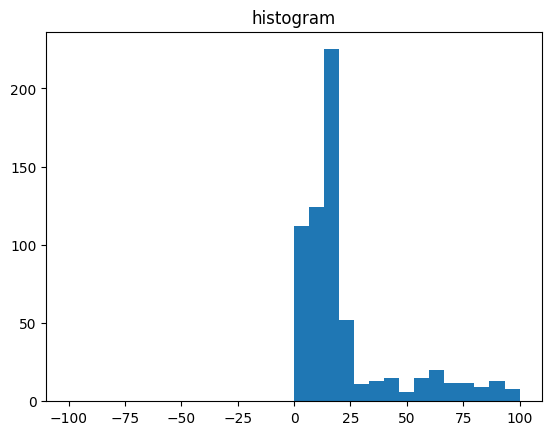

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
loss_norm = F.l1_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm))

mse_norm = F.mse_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm),reduction='sum')
rmse_norm = torch.sqrt(mse_norm/num_samples/grid_space)

print(loss_norm)
print(rmse_norm)
current_index = 26
print(current.shape)

z_plane_index= 8
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[-8,7,-12]
vmax=[-1 , 17, -2]
MSE_temp = 0
my_error = 0

ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    B_est_temp = B_est[current_index,i-1,:,:,z_plane_index]
    # B_est_temp = B_est[current_index,i-1,:,:,:]
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est_temp*1000)    #,vmin=vmin[i-1],vmax=vmax[i-1]
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    Bfield_temp = Bfield[current_index,i-1,:,:,z_plane_index]
    # Bfield_temp = Bfield[current_index,i-1,:,:,:]*1000
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_temp*1000)
    plt.colorbar()
    # print('B_est_temp:',B_est_temp)
    # print('Bfield_temp:',Bfield_temp)
    MSE_temp += F.mse_loss(torch.tensor(B_est_temp),torch.tensor(Bfield_temp),reduction='sum')
    my_error += np.sum((B_est_temp-Bfield_temp)**2)

plt.show()
RMSE_temp = torch.sqrt(MSE_temp/grid_x/grid_y)
RMSE_my = np.sqrt(my_error/grid_x/grid_y)
print('example RMSE:',RMSE_temp)
print('my RMSE:', RMSE_my)
from pylab import *
subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
fig, ax = plt.subplots(3, 1)
fig.tight_layout()

for i in range(1,4):
    plt.subplot(3,1,i)
    plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
    plt.colorbar(fraction=0.04)    

plt.show()

plt.hist(Error_CNN[current_index,:,:,:,z_plane_index].reshape(-1),bins=30,range=[-1.0e2,1.0e2])
plt.title("histogram") 
plt.show()